<a href="https://colab.research.google.com/github/Riiishaab/Sign_Language_Detector/blob/main/Sign_Language_Detector_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# View Fast ViT Model Family by Apple

In [1]:
import pandas as pd
import timm
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
pd.DataFrame(timm.list_models('*fastvit*', pretrained=True))

,0
0,fastvit_ma36.apple_dist_in1k
1,fastvit_ma36.apple_in1k
2,fastvit_mci0.apple_mclip
3,fastvit_mci1.apple_mclip
4,fastvit_mci2.apple_mclip
5,fastvit_s12.apple_dist_in1k
6,fastvit_s12.apple_in1k
7,fastvit_sa12.apple_dist_in1k
8,fastvit_sa12.apple_in1k
9,fastvit_sa24.apple_dist_in1k


## We choose FastViT_t8 Model

In [3]:
from timm.models import swin_transformer
swin_model = 'fastvit_t8.apple_in1k'
config = swin_transformer.default_cfgs[swin_model]
print(dir(config))  # This will show all attributes and methods

['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'cfgs', 'default', 'default_with_tag', 'is_pretrained', 'tags']


# Dataset

## Hagrid-Classification-512p-No-Gesture-150k Dataset from Hugging Face

#### url - https://huggingface.co/datasets/cj-mills/hagrid-classification-512p-no-gesture-150k

#### It has 19 Classes of Different Sign Languages. (About 150k Images)

In [4]:
# Install the datasets library if you haven't already
!pip install datasets

# Load the dataset directly
from datasets import load_dataset

# Load the dataset from Hugging Face Hub
dataset = load_dataset("cj-mills/hagrid-classification-512p-no-gesture-150k")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
print(dataset)

# Get class names using one of the two methods
if 'label' in dataset['train'].features and hasattr(dataset['train'].features['label'], 'names'):
    class_names = dataset['train'].features['label'].names
    print(f"Num classes: {len(class_names)}")
    print(class_names)
else:
    # Extract unique labels
    labels = set()
    for i in range(min(100, len(dataset['train']))):
        labels.add(dataset['train'][i]['label'])

    class_names = sorted(list(labels))
    print(f"Num classes: {len(class_names)}")
    print(class_names)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 153735
    })
})
Num classes: 19
['call', 'dislike', 'fist', 'four', 'like', 'mute', 'no_gesture', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']


## Verifying the Dataset

Class: call
Image Dims: (499, 480)


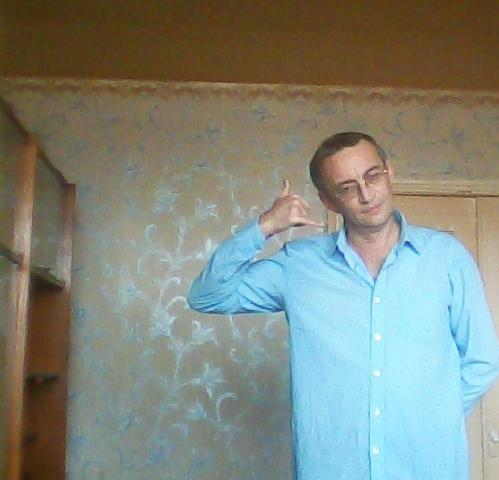

In [6]:
# Get the first image from the dataset
example = dataset['train'][0]
img = example['image']  # This is already a PIL Image object
label = example['label']

# If the label is an integer, convert it to the class name if available
if hasattr(dataset['train'].features['label'], 'names'):
    class_name = dataset['train'].features['label'].names[label]
else:
    class_name = str(label)  # Just use the label value as string

print(f"Class: {class_name}")
print(f"Image Dims: {img.size}")  # PIL images use .size not .shape

# Display the image
img


## Creating Train-Val Split and creating DataLoaders

In [7]:
# Install required packages
!pip install datasets torchvision

# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to square
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with 50% probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.RandomAffine(
        degrees=0,  # No rotation as per original
        translate=(0.1, 0.1),  # Small translations
        scale=(1.0, 1.1),  # Zoom between 1.0 and 1.1 as per original
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Custom Dataset class
class HFImageDataset(Dataset):
    def __init__(self, dataset, split='train', transform=None):
        self.dataset = dataset[split]
        self.transform = transform
        self.class_names = (
            dataset[split].features['label'].names
            if hasattr(dataset[split].features['label'], 'names')
            else [str(i) for i in range(len(set(dataset[split]['label'])))]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create train dataset
train_dataset = HFImageDataset(dataset, split='train', transform=train_transforms)

# Check if validation split exists, else create one
if 'validation' in dataset:
    valid_dataset = HFImageDataset(dataset, split='validation', transform=valid_transforms)
else:
    # Create validation split from train
    indices = list(range(len(train_dataset)))
    train_indices, valid_indices = train_test_split(indices, test_size=0.2, random_state=42)

    # Create subsets
    train_subset = Subset(train_dataset, train_indices)
    # For validation, we need to create a new dataset with validation transforms
    valid_dataset_base = HFImageDataset(dataset, split='train', transform=valid_transforms)
    valid_subset = Subset(valid_dataset_base, valid_indices)

    # Reassign for consistency in the next steps
    train_dataset = train_subset
    valid_dataset = valid_subset

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Display information about the dataloaders
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of classes: {len(train_dataset.dataset.class_names if isinstance(train_dataset, Subset) else train_dataset.class_names)}")

Number of training batches: 3844
Number of validation batches: 961
Number of classes: 19


## Transfer Learning withFast ViT Model for 4 Epochs

Model: fastvit_t8.apple_in1k
Extracting training images...
Processed 0 images
Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images
Processed 8000 images
Processed 9000 images
Processed 10000 images
Processed 11000 images
Processed 12000 images
Processed 13000 images
Processed 14000 images
Processed 15000 images
Processed 16000 images
Processed 17000 images
Processed 18000 images
Processed 19000 images
Processed 20000 images
Processed 21000 images
Processed 22000 images
Processed 23000 images
Processed 24000 images
Processed 25000 images
Processed 26000 images
Processed 27000 images
Processed 28000 images
Processed 29000 images
Processed 30000 images
Processed 31000 images
Processed 32000 images
Processed 33000 images
Processed 34000 images
Processed 35000 images
Processed 36000 images
Processed 37000 images
Processed 38000 images
Processed 39000 images
Processed 40000 images
Processed 4

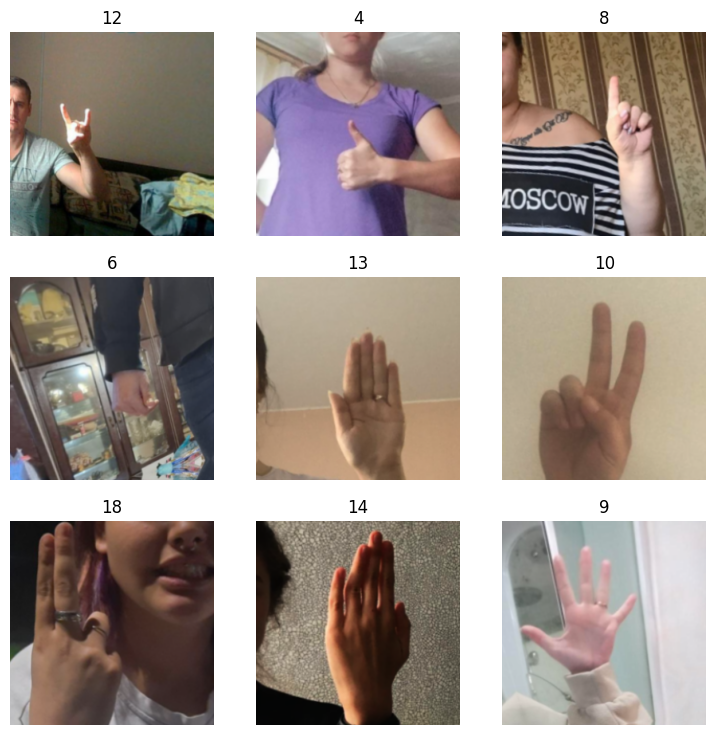

In [8]:
from fastai.vision.all import *
import timm
import pandas as pd

# Set up paths and model
fastvit_model = 'fastvit_t8.apple_in1k'  # Non-distilled version
# Alternative: 'fastvit_t8.apple_dist_in1k' for the distilled version

# Print model information
print(f"Model: {fastvit_model}")

# Load the dataset from Hugging Face
from datasets import load_dataset

# Load the HAGRID dataset
dataset = load_dataset("cj-mills/hagrid-classification-512p-no-gesture-150k")

# Create a temporary directory to store the images
import os
from pathlib import Path
import shutil

# Set up directories
data_path = Path('hagrid_data')
train_path = data_path/'train'
valid_path = data_path/'valid'

# Create directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(valid_path, exist_ok=True)

# Function to extract images from the dataset to a folder structure
def extract_dataset_to_folders(dataset_split, output_path):
    # Get unique labels
    labels = set()
    for item in dataset_split:
        labels.add(item['label'])

    # Create class folders
    for label in labels:
        os.makedirs(output_path/str(label), exist_ok=True)

    # Save images to appropriate folders
    for i, item in enumerate(dataset_split):
        img = item['image']
        label = item['label']
        img_path = output_path/str(label)/f"{i}.jpg"
        img.save(img_path)

        # Print progress
        if i % 1000 == 0:
            print(f"Processed {i} images")

# Extract train and validation sets (if validation exists)
print("Extracting training images...")
extract_dataset_to_folders(dataset['train'], train_path)

if 'validation' in dataset:
    print("Extracting validation images...")
    extract_dataset_to_folders(dataset['validation'], valid_path)
else:
    # If no validation set, create one from train
    print("Creating validation set from training data...")
    # Get list of class folders
    class_folders = [f for f in train_path.iterdir() if f.is_dir()]

    for class_folder in class_folders:
        # Create corresponding validation folder
        valid_class_folder = valid_path/class_folder.name
        os.makedirs(valid_class_folder, exist_ok=True)

        # Get all images in this class
        images = list(class_folder.glob('*.jpg'))

        # Move 20% to validation
        val_size = int(len(images) * 0.2)
        for img_path in images[:val_size]:
            shutil.move(str(img_path), str(valid_class_folder/img_path.name))

# Set up DataBlock and DataLoaders
size = 256  # FastViT T8 expects 256x256 images
batch_size = 32

# Use standard ImageNet mean and std values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Create DataLoaders - explicitly specifying train and valid folders
dls = ImageDataLoaders.from_folder(
    data_path,
    train='train',
    valid='valid',
    item_tfms=[Resize(size)],
    batch_tfms=[
        *aug_transforms(size=size, min_scale=0.9),
        Normalize.from_stats(mean, std)
    ],
    bs=batch_size
)

# Show a batch to verify
dls.show_batch()


In [9]:
print(f"Validation set size: {len(dls.valid)}")
print(f"Validation items: {dls.valid.items[:5]}")  # Show first 5 items


Validation set size: 961
Validation items: [Path('hagrid_data/valid/3/27403.jpg'), Path('hagrid_data/valid/3/26093.jpg'), Path('hagrid_data/valid/3/27392.jpg'), Path('hagrid_data/valid/3/23853.jpg'), Path('hagrid_data/valid/3/27821.jpg')]


# Training and Evaluation

Finding optimal learning rate...


Using learning rate: 0.005213402328081429
Training for 4 epochs...


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.432700,0.332274,0.889652,20:42
1,0.256318,0.181208,0.943232,20:18
2,0.168166,0.093394,0.970136,20:58
3,0.108531,0.076081,0.975308,20:26


Model saved to hagrid-fastvit_t8.apple_in1k.pth
Model evaluation:


Model exported to hagrid-fastvit_t8.apple_in1k.pkl


Image from class: 16
Predicted: 16 with probability 1.0000


Image from class: 18
Predicted: 18 with probability 0.8548


Image from class: 6
Predicted: 6 with probability 0.9999


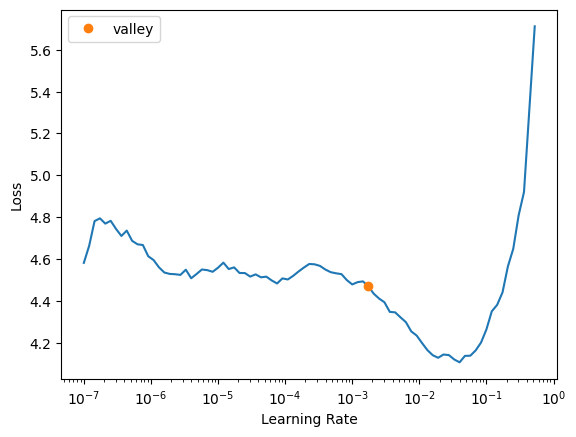

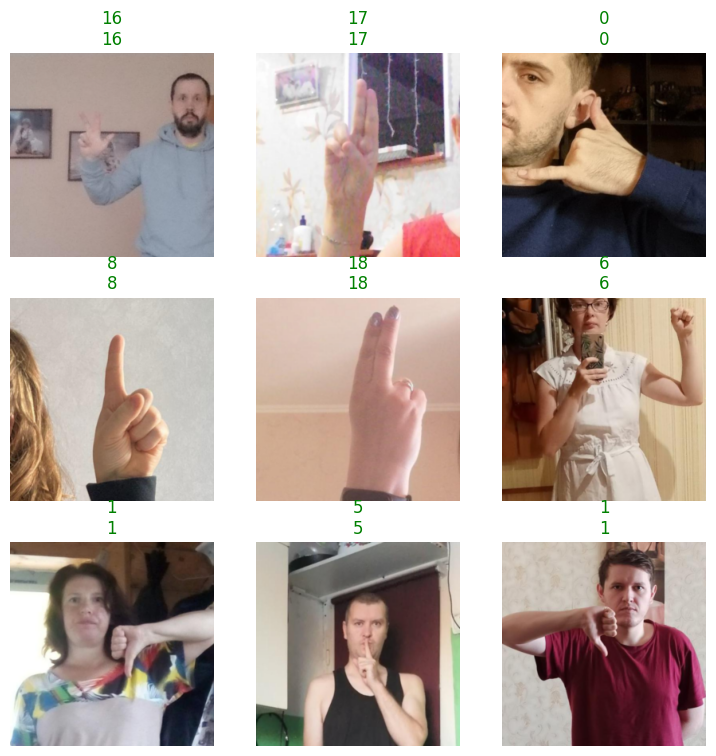

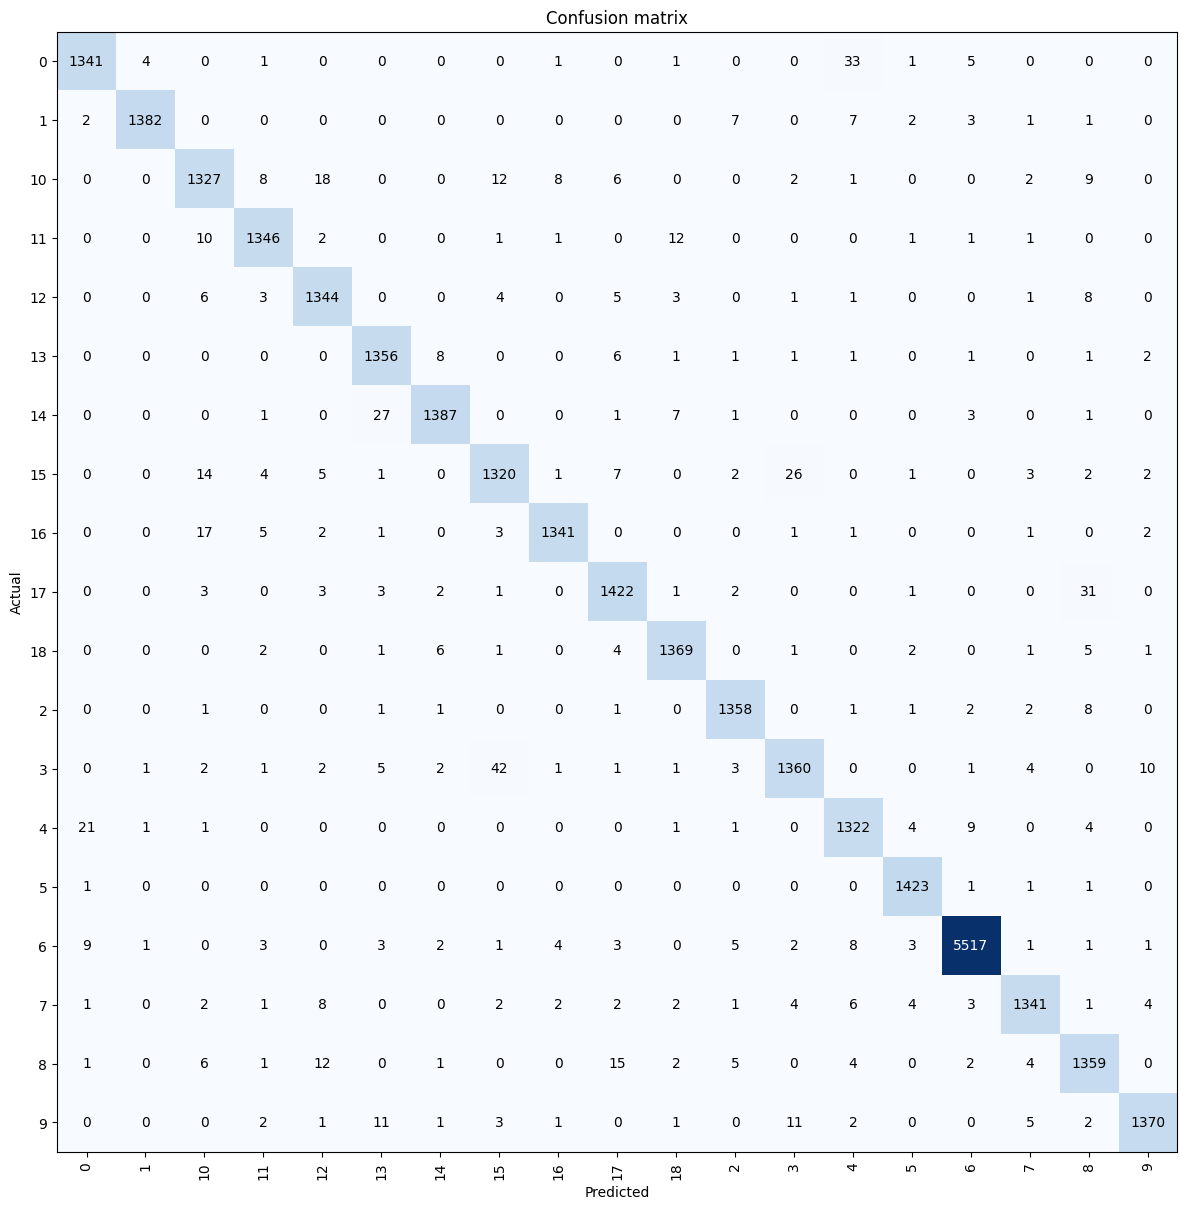

In [10]:
# Create the learner
model_name = fastvit_model  # Use the FastViT model instead of ConvNeXT
metrics = [accuracy]

# Create vision learner with the FastViT model
learn = vision_learner(dls, model_name, metrics=metrics)

# Set up checkpoint path
checkpoint_path = Path(f"hagrid-{model_name}.pth")

# Find optimal learning rate
print("Finding optimal learning rate...")
suggested_lrs = learn.lr_find()
lr = suggested_lrs.valley * 3
print(f"Using learning rate: {lr}")

# Train the model
epochs = 4

# Use simpler callbacks to avoid the issue
cbs = [
    MixedPrecision(),  # Keep mixed precision for faster training
]

print(f"Training for {epochs} epochs...")
# Use fit_one_cycle instead of fine_tune to simplify
learn.fit_one_cycle(epochs, lr, cbs=cbs)

# Save the model manually after training
learn.save(checkpoint_path.stem)
print(f"Model saved to {checkpoint_path}")

# Evaluate the model
print("Model evaluation:")
learn.show_results()

# Try to create the interpretation - this might fail if validation data isn't properly set up
try:
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(figsize=(12, 12))
except Exception as e:
    print(f"Could not create interpretation: {e}")

# Export the model
learn.export(f'hagrid-{model_name}.pkl')
print(f"Model exported to hagrid-{model_name}.pkl")

# Test on a few random images
from random import choice
test_files = list((data_path/'valid').glob('*/*.jpg'))
if test_files:  # Check if there are any test files
    for _ in range(min(3, len(test_files))):
        test_file = choice(test_files)
        img = PILImage.create(test_file)
        pred_class, pred_idx, probs = learn.predict(img)
        print(f"Image from class: {test_file.parent.name}")
        print(f"Predicted: {pred_class} with probability {probs[pred_idx]:.4f}")
else:
    print("No test files found.")


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score
from fastai.metrics import accuracy

# Get predictions on the validation set
preds, targets = learn.get_preds()
pred_classes = preds.argmax(dim=1)

# Calculate metrics
acc = accuracy(preds, targets).item()  # Convert tensor to float with .item()
prec = precision_score(targets.cpu().numpy(), pred_classes.cpu().numpy(), average='weighted')
rec = recall_score(targets.cpu().numpy(), pred_classes.cpu().numpy(), average='weighted')
f1 = f1_score(targets.cpu().numpy(), pred_classes.cpu().numpy(), average='weighted')
kappa = cohen_kappa_score(targets.cpu().numpy(), pred_classes.cpu().numpy())

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Cohen\'s Kappa: {kappa:.4f}')


Accuracy: 0.9755
Precision: 0.9756
Recall: 0.9755
F1 Score: 0.9755
Cohen's Kappa: 0.9736


# Saving Full Model to Load and use Later

In [18]:
# Save the entire fastai learner (architecture + weights + transforms)
learn.export('my_full_learner.pkl')
